In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from imutils.object_detection import non_max_suppression
%matplotlib inline

In [2]:
INPUT_DATA = "000.dat"
INPUT_VIDEO = "0.MOV"
G_ROW_DISTANCE = 11
STARTROW = G_row = 9
frame = 0

In [3]:
# Grab Data
data = pd.read_csv(INPUT_DATA, header=None) 
col_names = ["frame", "timestamp", "x_accel", "y_accel", "z_accel"] 
processed_data = pd.DataFrame(index=range(len(data)-STARTROW) , columns=col_names) 
for row in range(STARTROW, len(data)): 
    if row == G_row: 
        # Process the G data 
        split = str(data.iloc[row]).split("\\t") 
        timestamp = (split[1].split(" ")[1])
        G_row += G_ROW_DISTANCE
    else: 
        processed_data.loc[[row-STARTROW], "frame"] = frame
        processed_data.loc[[row-STARTROW], "timestamp"] = timestamp
        # Process the S data 
        split = str(data.iloc[row]).split("\\t") 
        z_accel = split[3].split("\n")[0] 
        processed_data.loc[[row-STARTROW], "x_accel"] = float(split[1])
        processed_data.loc[[row-STARTROW], "y_accel"] = float(split[2])
        processed_data.loc[[row-STARTROW], "z_accel"] = float(z_accel)
        frame += 1
processed_data = processed_data.dropna(how="all")

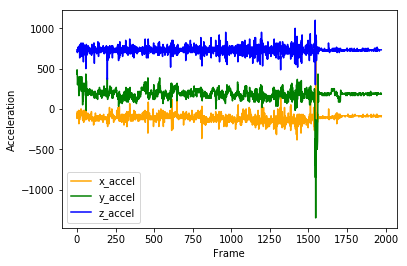

In [4]:
ax = processed_data.plot(kind='line',x='frame',y=['x_accel', 'y_accel', 'z_accel'],color=['orange', 'green','blue'])
ax.set(xlabel='Frame', ylabel='Acceleration')
plt.show()

In [5]:
col_names = ["frame","timestamp","delta_sum", "delta_x", "delta_y", "delta_z"]
delta = pd.DataFrame(index=range(1), columns = col_names)
previous_x = previous_y = previous_z = None
for index, row in processed_data.iterrows():
    x,y,z = float(row["x_accel"]), float(row["y_accel"]), float(row["z_accel"])
    timestamp = row["timestamp"]
    frame = row["frame"]
    if previous_x is None:
        previous_x, previous_y , previous_z = x, y, z
    else:
        delta_x, delta_y, delta_z = abs(x - previous_x), abs(y - previous_y), abs(z - previous_z)
        delta_sum = delta_x + delta_y + delta_z
        new_row = pd.DataFrame([[frame,timestamp,delta_sum, delta_x, delta_y, delta_z]], columns=col_names)
        delta = delta.append(new_row, ignore_index=True)
    delta = delta.dropna(how="all")

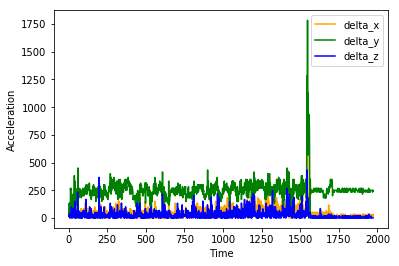

In [7]:
ax = delta.plot(kind='line',x='frame',y=['delta_x', 'delta_y', 'delta_z'],color=['orange', 'green','blue'])
ax.set(xlabel='Time', ylabel='Acceleration')
plt.show()

In [8]:
crash_index=delta["delta_y"].idxmax()
frame_num = processed_data.iloc[crash_index].frame
if(crash_index > 500):
    print("I think a crash happened here:")
    print(processed_data.iloc[crash_index])

I think a crash happened here:
frame            1546
timestamp    15:51:43
x_accel          -118
y_accel          -367
z_accel           651
Name: 1701, dtype: object


In [9]:
print("The change in the Y acceleration at "+
      str(processed_data.iloc[crash_index].timestamp)+
       " was "+str(delta.iloc[crash_index].delta_y))
print("This is a very high acceleration and indicates a crash.")

The change in the Y acceleration at 15:51:43 was 1785.0
This is a very high acceleration and indicates a crash.


In [10]:
# Proccess video
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
cap = cv2.VideoCapture(str(INPUT_VIDEO))

In [11]:
# Get number of frames and set starting frame
# frame_num needs to be altered to move from dat to video frame
# // is integer division
LAST_FRAME = cap.get(cv2.CAP_PROP_FRAME_COUNT)
START_FRAME = frame_num = frame_num * LAST_FRAME // len(processed_data)
FRAMERATE = 30

cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

while frame_num < LAST_FRAME:
    res, frame = cap.read()
    (rects, weights) = hog.detectMultiScale(frame, winStride=(16,16), padding=(8,8), scale=1.06)
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)
    if(len(rects) > 0):
        print("Pedestrian Detected "+str( (frame_num - START_FRAME) // 30 )+" seconds after accident")

    for(xA,yA,xB,yB) in pick:
        cv2.rectangle(frame, (xA,yA), (xB, yB), (0,0,255),2)
    
    cv2.imwrite('images/frame_'+str(frame_num)+'bounded.jpg',frame)
    cv2.imshow('Bounded_Frame',frame)
    cv2.waitKey(0)
    
    frame_num += FRAMERATE
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)


Pedestrian Detected 19.0 seconds after accident
Pedestrian Detected 39.0 seconds after accident
Pedestrian Detected 40.0 seconds after accident
Pedestrian Detected 41.0 seconds after accident
Pedestrian Detected 42.0 seconds after accident
Pedestrian Detected 43.0 seconds after accident
Pedestrian Detected 44.0 seconds after accident


In [16]:
frame_num = 1
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)

while frame_num < LAST_FRAME:
    res, frame = cap.read()
    (rects, weights) = hog.detectMultiScale(frame, winStride=(16,16), padding=(8,8), scale=1.06)
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)
    if(len(rects) > 0):
        print("Pedestrian Detected "+str( (frame_num) // 30 )+" seconds into video")

        for(xA,yA,xB,yB) in pick:
            cv2.rectangle(frame, (xA,yA), (xB, yB), (0,0,255),2)
    
        #cv2.imwrite('images/Pedestrians/frame_'+str(frame_num)+'bounded.jpg',frame)
        cv2.imshow('Bounded_Frame',frame)
        cv2.waitKey(0)
    
    frame_num += FRAMERATE
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)


Pedestrian Detected 11 seconds into video
Pedestrian Detected 17 seconds into video
Pedestrian Detected 22 seconds into video
Pedestrian Detected 40 seconds into video
Pedestrian Detected 103 seconds into video
Pedestrian Detected 107 seconds into video
Pedestrian Detected 153 seconds into video
Pedestrian Detected 199 seconds into video
Pedestrian Detected 200 seconds into video
Pedestrian Detected 201 seconds into video
Pedestrian Detected 202 seconds into video
Pedestrian Detected 203 seconds into video
